In [ ]:
# Install kaggle API
!pip install -q kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

# Create a kaggle directory and move kaggle.json there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

# Unzip the dataset
# !unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 77% 67.0M/86.8M [00:00<00:00, 165MB/s]
100% 86.8M/86.8M [00:00<00:00, 164MB/s]


In [ ]:
! unzip brain-tumor-classification-mri.zip

Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  infl

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_path = "Training"
test_path = "Testing"

In [ ]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",test_set)

{'glioma_tumor': 826, 'pituitary_tumor': 827, 'meningioma_tumor': 822, 'no_tumor': 395} 

 {'glioma_tumor': 100, 'pituitary_tumor': 74, 'meningioma_tumor': 115, 'no_tumor': 105}


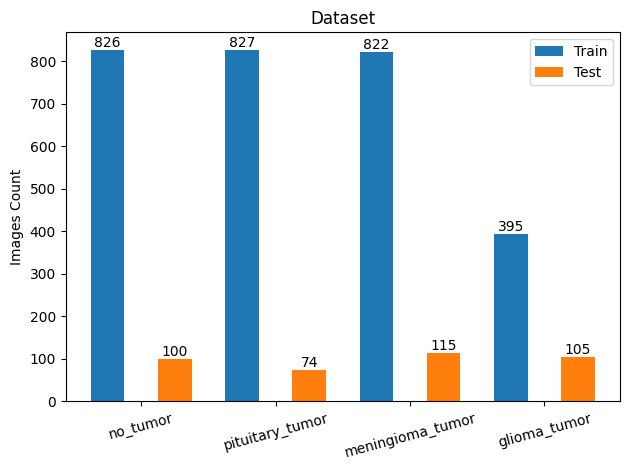

In [ ]:
labels = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

train_list = list(train_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects3 = ax.bar(x + width, test_list, width, label='Test')

ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()
ax.bar_label(rects1)
ax.bar_label(rects3)

fig.tight_layout()
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

train_data.class_indices

Found 2870 images belonging to 4 classes.


{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_data = train_datagen.flow_from_directory(
    train_path,
    batch_size=5,
    target_size=(350, 350),
    class_mode='categorical'
)

print(train_data.class_indices)

Found 2870 images belonging to 4 classes.
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')
test_data.class_indices

Found 394 images belonging to 4 classes.


{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

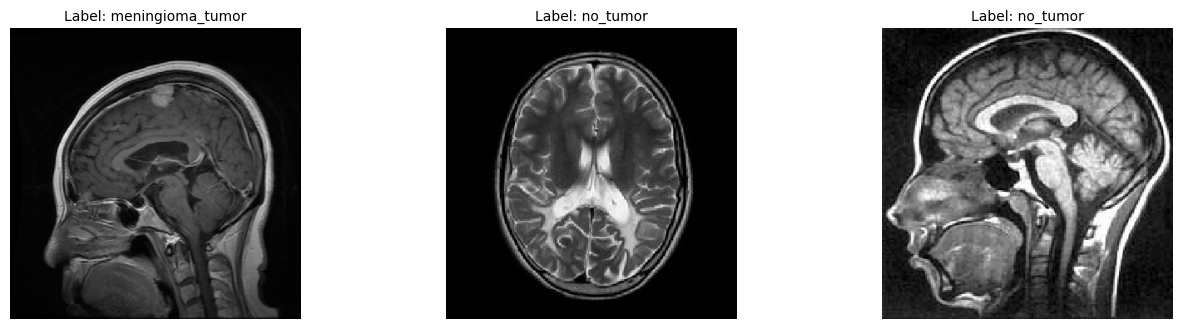

In [ ]:
def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    fig.subplots_adjust(wspace=0.5)

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title("Label: {}".format(class_labels[np.argmax(labels[i])]), fontsize=10)  # Adjust fontsize as needed
        axs[i].axis('off')

    plt.show()

sample_images, sample_labels = next(train_data)
plot_sample_images(sample_images[:3], sample_labels[:3], train_data.class_indices)

In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(350,350,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
NUM_CLASSES = 4

vgg_model = Sequential()

vgg_model.add(base_model)

vgg_model.add(layers.Flatten())

vgg_model.add(layers.Dropout(0.25))

vgg_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg_model.layers[0].trainable = False

vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
mc = ModelCheckpoint(
    filepath="Brain_Tumor.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );

call_back = [ mc];

In [ ]:
vgg = vgg_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=32,
    callbacks=call_back
)

Epoch 1/32
574/574 [==============================] - ETA: 0s - loss: 1.0527 - accuracy: 0.7488

574/574 [==============================] - 48s 72ms/step - loss: 1.0527 - accuracy: 0.7488
Epoch 2/32
574/574 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.8843

574/574 [==============================] - 44s 76ms/step - loss: 0.5049 - accuracy: 0.8843
Epoch 3/32
574/574 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.9118

574/574 [==============================] - 46s 80ms/step - loss: 0.3992 - accuracy: 0.9118
Epoch 4/32
574/574 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9432

574/574 [==============================] - 45s 78ms/step - loss: 0.2171 - accuracy: 0.9432
Epoch 5/32
574/574 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9554

574/574 [==============================] - 45s 79ms/step - loss: 0.1702 - accuracy: 0.9554
Epoch 6/32
574/574 [==============================] - ETA: 0s - loss: 0.2358 - accuracy: 0.9495

574/574 [==============================] - 45s 78ms/step - loss: 0.2358 - accuracy: 0.9495
Epoch 7/32
574/574 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.9578

574/574 [==============================] - 46s 80ms/step - loss: 0.1919 - accuracy: 0.9578
Epoch 8/32
574/574 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9721

574/574 [==============================] - 45s 78ms/step - loss: 0.1070 - accuracy: 0.9721
Epoch 9/32
574/574 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9704

574/574 [==============================] - 46s 80ms/step - loss: 0.1490 - accuracy: 0.9704
Epoch 10/32
574/574 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9599

574/574 [==============================] - 46s 79ms/step - loss: 0.2586 - accuracy: 0.9599
Epoch 11/32
574/574 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.9638

574/574 [==============================] - 45s 78ms/step - loss: 0.2167 - accuracy: 0.9638
Epoch 12/32
574/574 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.9780

574/574 [==============================] - 46s 80ms/step - loss: 0.1196 - accuracy: 0.9780
Epoch 13/32
574/574 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.9526

574/574 [==============================] - 46s 79ms/step - loss: 0.2852 - accuracy: 0.9526
Epoch 14/32
574/574 [==============================] - ETA: 0s - loss: 0.1420 - accuracy: 0.9777

574/574 [==============================] - 45s 78ms/step - loss: 0.1420 - accuracy: 0.9777
Epoch 15/32
574/574 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9787

574/574 [==============================] - 46s 80ms/step - loss: 0.1124 - accuracy: 0.9787
Epoch 16/32
574/574 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9899

574/574 [==============================] - 46s 79ms/step - loss: 0.0517 - accuracy: 0.9899
Epoch 17/32
574/574 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9871

574/574 [==============================] - 45s 78ms/step - loss: 0.0793 - accuracy: 0.9871
Epoch 18/32
574/574 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9805

574/574 [==============================] - 45s 79ms/step - loss: 0.1054 - accuracy: 0.9805
Epoch 19/32
574/574 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9878

574/574 [==============================] - 45s 78ms/step - loss: 0.0718 - accuracy: 0.9878
Epoch 20/32
574/574 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.9805

574/574 [==============================] - 45s 78ms/step - loss: 0.1481 - accuracy: 0.9805
Epoch 21/32
574/574 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9801

574/574 [==============================] - 45s 79ms/step - loss: 0.1268 - accuracy: 0.9801
Epoch 22/32
574/574 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.9791

574/574 [==============================] - 45s 79ms/step - loss: 0.1480 - accuracy: 0.9791
Epoch 23/32
574/574 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9882

574/574 [==============================] - 45s 79ms/step - loss: 0.0640 - accuracy: 0.9882
Epoch 24/32
574/574 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9899

574/574 [==============================] - 46s 80ms/step - loss: 0.0773 - accuracy: 0.9899
Epoch 25/32
574/574 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9805

574/574 [==============================] - 45s 78ms/step - loss: 0.1905 - accuracy: 0.9805
Epoch 26/32
574/574 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9840

574/574 [==============================] - 45s 79ms/step - loss: 0.0924 - accuracy: 0.9840
Epoch 27/32
574/574 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9909

574/574 [==============================] - 45s 78ms/step - loss: 0.0571 - accuracy: 0.9909
Epoch 28/32
574/574 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9868

574/574 [==============================] - 45s 79ms/step - loss: 0.0835 - accuracy: 0.9868
Epoch 29/32
574/574 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.9784

574/574 [==============================] - 45s 79ms/step - loss: 0.1590 - accuracy: 0.9784
Epoch 30/32
574/574 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9923

574/574 [==============================] - 46s 80ms/step - loss: 0.0512 - accuracy: 0.9923
Epoch 31/32
574/574 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9927

574/574 [==============================] - 45s 78ms/step - loss: 0.0542 - accuracy: 0.9927
Epoch 32/32
574/574 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9913

574/574 [==============================] - 45s 79ms/step - loss: 0.0499 - accuracy: 0.9913


In [ ]:
vgg_model.save('Brain_Tumor.hdf5')